In [4]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

In [6]:
base_path = "/home/jinjinjara1022/"

# weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
# weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

# weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
# weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

# jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

In [21]:
df = jeju_power_market_day_ahead

In [22]:
df['datetimes'] = pd.to_datetime(df['ts'], unit='s')
df['hour'] = df['datetimes'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df = df.drop(['ts', 'datetimes', 'hour'], axis=1)

df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]
df

,hour_sin,hour_cos,하루전가격(원/kWh)
0,-7.071068e-01,-7.071068e-01,107.39
1,-8.660254e-01,-5.000000e-01,107.39
2,-9.659258e-01,-2.588190e-01,95.30
3,-1.000000e+00,-1.836970e-16,87.89
4,-9.659258e-01,2.588190e-01,0.00
...,...,...,...
5660,2.588190e-01,-9.659258e-01,156.68
5661,1.224647e-16,-1.000000e+00,152.54
5662,-2.588190e-01,-9.659258e-01,106.92
5663,-5.000000e-01,-8.660254e-01,150.97


In [23]:
cols = ['hour_sin', 'hour_cos', 'ahead_price']
df.columns = cols

In [24]:
df

,hour_sin,hour_cos,ahead_price
0,-7.071068e-01,-7.071068e-01,107.39
1,-8.660254e-01,-5.000000e-01,107.39
2,-9.659258e-01,-2.588190e-01,95.30
3,-1.000000e+00,-1.836970e-16,87.89
4,-9.659258e-01,2.588190e-01,0.00
...,...,...,...
5660,2.588190e-01,-9.659258e-01,156.68
5661,1.224647e-16,-1.000000e+00,152.54
5662,-2.588190e-01,-9.659258e-01,106.92
5663,-5.000000e-01,-8.660254e-01,150.97


In [25]:
y = df['ahead_price']
x = df.drop('ahead_price', axis=1)

In [32]:
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = int(len(y) * 0.2))
print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

train data shape
x:(4532, 2), y:(4532,)


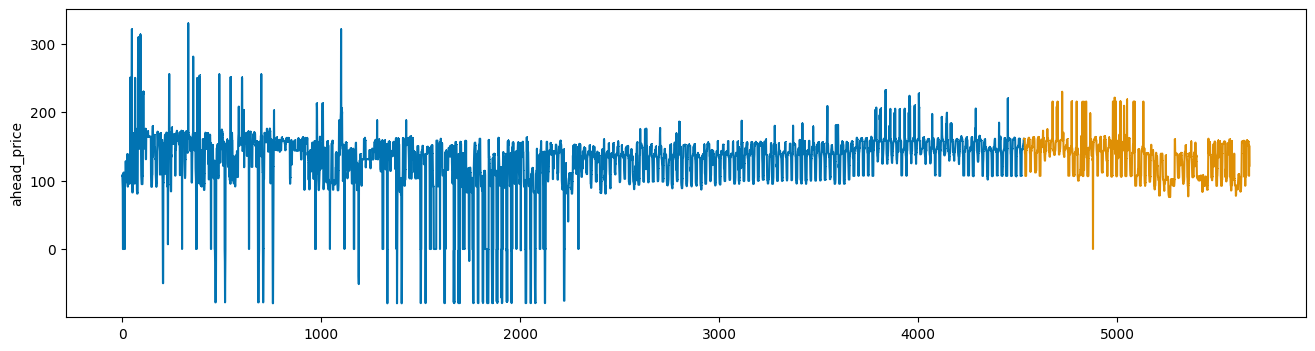

In [33]:
plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [34]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [37]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [41]:
import xgboost as xgb
print(xgb.__version__)


2.1.1


In [44]:
# XGBRegressor 모델 생성
xgb_reg = XGBRegressor(
    n_estimators=100, 
    eta=0.01,                # 학습률
    min_child_weight=1,      # 최소 가중치
    max_depth=6,             # 최대 깊이
    colsample_bytree=0.8,    # 컬럼 샘플링 비율
    subsample=0.8,           # 데이터 샘플링 비율
    seed=0
)

xgb_reg.fit(
    x_train, y_train, 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    #early_stopping_rounds=300, 
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

SMAPE : 8.627788680262944


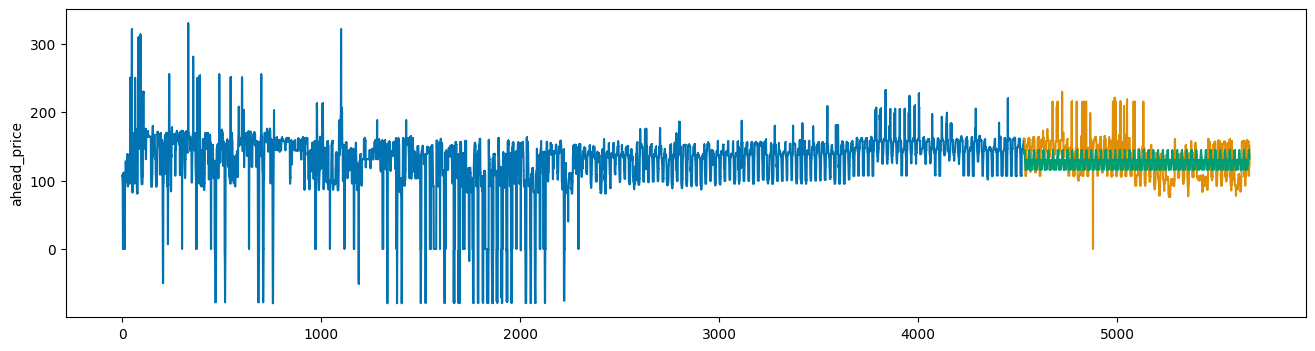

In [47]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_valid, pred)))